In [1]:
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/all_sales.csv", encoding='latin-1')
print(df.shape)

(28626, 10)


In [3]:
df.head(3)

,Unnamed: 0,Address,Apt,bedroom,bathroom,size,intro,photo,price,price(k)
0,3,1 5th Avenue,9B,2.0,2.0,1150.0,Please call to schedule a private viewing Buil...,['https://d2787ndpv5cwhz.cloudfront.net/453a7f...,2850000,2850.0
1,6,1 Bay Club Dr,11D,2.0,2.0,1400.0,Renovated Large 2 Bedroom 2 Bathroom. Nice Wat...,['http://photos.v3.mlsstratus.com/Live/photos/...,938000,938.0
2,8,1 Bay Club Dr,16-A,2.0,2.0,1250.0,Stunning Hi Floor 2 Bedroom-2 Baths Filled Wit...,['http://photos.v3.mlsstratus.com/Live/photos/...,899000,899.0


## train customer words embedding

In [ ]:
corpus = df["intro"].values
# we need to pass splitted sentences to the model
tokenized_sentences = [sentence.split() for sentence in corpus if type(sentence)==str and len(sentence)>3]

In [ ]:
# train model
model20 = Word2Vec(tokenized_sentences, 
                 min_count=3,   # Ignore words that appear less than this
                 size=20,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5)      # Context window for words during training

In [ ]:
model20.save('data/model20.bin')

In [4]:
model = Word2Vec.load('data/model20.bin')

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
def parse(df, embedding, number):
    word_vector = np.zeros((number,))
    for intro in df["intro"].values:
        if type(intro)==str:
            token = intro.split()
            s = np.zeros((number,))
            for i in token:
                i = i.lower()
                try:
                    s = s + embedding[i]
                except:
                    s = s
            word_vector = np.vstack([word_vector, s])
        else:
            word_vector = np.vstack([word_vector, np.zeros((number,))])
    word_vector = word_vector[1:]
    sdf = pd.DataFrame(word_vector)
    df1 = pd.concat([df, sdf], axis=1)
    df1 = df1[~df1["price(k)"].isna()]
    return df1

In [6]:
df_self_train = parse(df, model, 20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## train and test

In [7]:
def inputdata(df_name, n):
    df_name = df_name[~df_name["price(k)"].isna()]
    df = df_name.sample(frac=1)
    vars_housing   = ['bedroom', 'bathroom', 'size'] + list(range(n))
    target_housing = ["price(k)"]
    X = df[vars_housing ] 
    y = df[target_housing ]
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    xscale=scaler_x.fit_transform(X)
    yscale=scaler_y.fit_transform(y)
    return xscale, yscale

In [10]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
def build_model(optimizer="adam"):
    model = Sequential()
    model.add(Dense(32, kernel_initializer='normal', activation=tf.nn.relu, input_shape=[23]))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, kernel_initializer='normal'))
#     optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [11]:
x, y = inputdata(df_self_train, 20)
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


# grid search

## Tune the Training Optimization Algorithm

In [16]:
# define the grid search parameters
estimator = KerasRegressor(build_fn=build_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="neg_mean_squared_error", 
                    n_jobs=-1, refit=False, verbose=1)
grid_result_opt = grid.fit(x, y)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 39.2min finished


In [18]:

# summarize results
print("Best: %f using %s" % (grid_result_opt.best_score_, grid_result_opt.best_params_))
means = grid_result_opt.cv_results_['mean_test_score']
stds = grid_result_opt.cv_results_['std_test_score']
params = grid_result_opt.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001323 using {'optimizer': 'Adadelta'}
-0.001495 (0.000100) with: {'optimizer': 'SGD'}
-0.002675 (0.001927) with: {'optimizer': 'RMSprop'}
-0.001599 (0.000452) with: {'optimizer': 'Adagrad'}
-0.001323 (0.000098) with: {'optimizer': 'Adadelta'}
-0.003815 (0.003591) with: {'optimizer': 'Adam'}
-0.002565 (0.001910) with: {'optimizer': 'Adamax'}
-0.004652 (0.004655) with: {'optimizer': 'Nadam'}


## Tune the Number of Neurons in the Hidden Layer

In [12]:
def build_model(neurons=2):
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer='normal', activation="relu", input_shape=[23]))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, kernel_initializer='normal'))
#     optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                optimizer="Adadelta",
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [13]:
# define the grid search parameters
estimator = KerasRegressor(build_fn=build_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [2, 6, 11, 16, 21, 26, 32]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="neg_mean_squared_error", 
                    n_jobs=-1, refit=False, verbose=1)
grid_result_neuron = grid.fit(x, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 41.6min finished


In [16]:

# summarize results
print("Best: %f using %s" % (grid_result_neuron.best_score_, grid_result_neuron.best_params_))
means = grid_result_neuron.cv_results_['mean_test_score']
stds = grid_result_neuron.cv_results_['std_test_score']
params = grid_result_neuron.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001345 using {'neurons': 21}
-0.001904 (0.000504) with: {'neurons': 2}
-0.001524 (0.000086) with: {'neurons': 6}
-0.001420 (0.000084) with: {'neurons': 11}
-0.001443 (0.000110) with: {'neurons': 16}
-0.001345 (0.000098) with: {'neurons': 21}
-0.001366 (0.000129) with: {'neurons': 26}
-0.001356 (0.000135) with: {'neurons': 32}


### Tune Batch Size and Number of Epochs

In [36]:
# define the grid search parameters
estimator = KerasRegressor(build_fn=build_model, verbose=False)
batch_size = [10, 20, 50, 100]
epochs = [200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="neg_mean_squared_error", 
                    n_jobs=-1, refit=False, verbose=1)
grid_result_epoch = grid.fit(x, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 46.8min finished


In [37]:

# summarize results
print("Best: %f using %s" % (grid_result_epoch.best_score_, grid_result_epoch.best_params_))
means = grid_result_epoch.cv_results_['mean_test_score']
stds = grid_result_epoch.cv_results_['std_test_score']
params = grid_result_epoch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001288 using {'batch_size': 50, 'epochs': 200}
-0.001373 (0.000049) with: {'batch_size': 10, 'epochs': 200}
-0.001321 (0.000045) with: {'batch_size': 20, 'epochs': 200}
-0.001288 (0.000004) with: {'batch_size': 50, 'epochs': 200}
-0.001380 (0.000099) with: {'batch_size': 100, 'epochs': 200}


## best model

In [133]:
def build_model():
    model = Sequential()
    model.add(Dense(21, kernel_initializer='normal', activation="relu", input_shape=[23]))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal'))
#     optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                optimizer="Adadelta",
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [134]:
x, y = inputdata(df_self_train, 20)
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 21)                504       
_________________________________________________________________
dropout_24 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 22        
Total params: 526
Trainable params: 526
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(x, y, epochs=200, batch_size=50, verbose=0, validation_split=0.2)

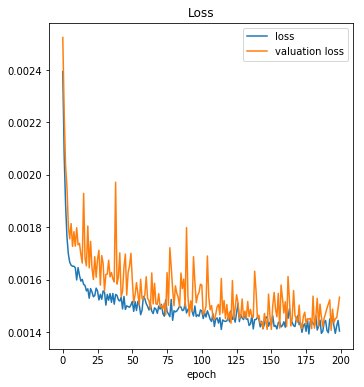

In [136]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

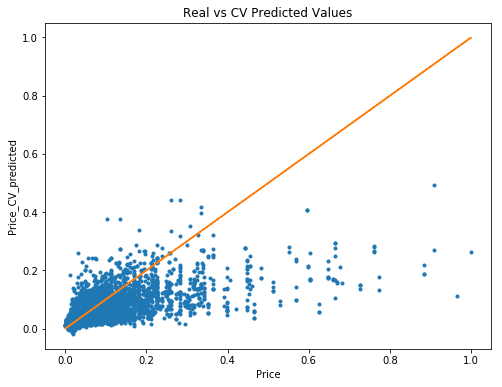

In [137]:
y_p = model.predict(x)

plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('Price')
plt.ylabel('Price_CV_predicted')
_ = plt.plot(y, y_p, '.', y, y, '-')